In [3]:
!git clone https://github.com/zzeiidann/Ristek-UI---Data-Competition.git


Cloning into 'Ristek-UI---Data-Competition'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 796.25 KiB | 3.59 MiB/s, done.


In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
import statsmodels.api as sm
from warnings import filterwarnings 
import optuna
from tqdm import tqdm
filterwarnings('ignore')

In [170]:
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import (
    KFold,
    train_test_split as tts,
    cross_val_score as cvs,
    cross_val_predict as cvp,
)
import shap
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import catboost as cb

In [242]:
train = pd.read_csv('/Users/mraffyzeidan/Documents/Code/Ristek - Updated/Ristek-UI---Data-Competition/ristek-data-competition/train.csv')
test = pd.read_csv('/Users/mraffyzeidan/Documents/Code/Ristek - Updated/Ristek-UI---Data-Competition/ristek-data-competition/test.csv')
sample = pd.read_csv('/Users/mraffyzeidan/Documents/Code/Ristek - Updated/Ristek-UI---Data-Competition/ristek-data-competition/sample_submission.csv')

------------------------------------------------------------------------------------------------

# 1. Load and Preprocessing

In [50]:
data = train.copy()
data.head(10)

timestamp  api_calls    clouds  distance_max  distance_mean  \
0  2018-11-26 06:00:00        9.0  0.990667          3.03       1.726667   
1  2018-11-26 07:00:00       10.0  0.970000          2.67       1.690000   
2  2018-11-26 08:00:00        1.0  0.980000          1.38       1.380000   
3  2018-11-26 09:00:00       11.0  1.000000          3.08       1.920909   
4  2018-11-26 10:00:00       12.0  0.995000          3.01       2.122500   
5  2018-11-26 11:00:00        6.0  0.955000          2.97       1.721667   
6  2018-11-26 12:00:00       12.0  0.920000          3.01       1.836667   
7  2018-11-26 13:00:00        9.0  0.910000          3.01       2.144444   
8  2018-11-26 14:00:00        9.0  0.905000          3.02       2.033333   
9  2018-11-26 15:00:00       10.0  0.925000          3.03       1.616000   

   distance_min  humidity  price_mean    rain  surge_max  surge_mean  \
0          1.04  0.913333   16.555556  0.0000       1.50    1.055556   
1          1.09  0.920000   17.300000  0.0000       2.00    1.100000   
2          1.38  0.923333   13.500000  0.0000       1.00    1.000000   
3          1.39  0.927500   17.954545  0.0000       1.75    1.113636   
4          1.07  0.940000   18.625000  0.0000       1.50    1.083333   
5          1.03  0.940000   15.083333  0.0000       1.00    1.000000   
6          1.07  0.935000   16.250000  0.0000       1.25    1.020833   
7          1.06  0.910000   19.888889  0.0031       2.00    1.222222   
8          1.04  0.910000   16.500000  0.0044       1.00    1.000000   
9          1.07  0.895000   14.750000  0.0000       1.00    1.000000   

   surge_min       temp      wind  type  
0        1.0  40.627333  1.350667     0  
1        1.0  41.137500  1.735000     0  
2        1.0  40.920000  1.330000     0  
3        1.0  40.937500  1.365000     0  
4        1.0  40.695000  1.895000     0  
5        1.0  40.185000  2.260000     0  
6        1.0  40.315000  2.940000     0  
7        1.0  41.950000  3.545000     0  
8        1.0  42.765000  2.960000     0  
9        1.0  43.760000  4.145000     0

In [51]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20355 entries, 0 to 20354
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      20355 non-null  datetime64[ns]
 1   api_calls      20355 non-null  float64       
 2   clouds         20163 non-null  float64       
 3   distance_max   20355 non-null  float64       
 4   distance_mean  20355 non-null  float64       
 5   distance_min   20355 non-null  float64       
 6   humidity       20163 non-null  float64       
 7   price_mean     20355 non-null  float64       
 8   rain           20163 non-null  float64       
 9   surge_max      20355 non-null  float64       
 10  surge_mean     20355 non-null  float64       
 11  surge_min      20355 non-null  float64       
 12  temp           20163 non-null  float64       
 13  wind           20163 non-null  float64       
 14  type           20355 non-null  int64         
 15  hour           2035

In [53]:
data.drop('timestamp', axis=1).corr()

api_calls    clouds  distance_max  distance_mean  distance_min  \
api_calls       1.000000  0.109195      0.153966       0.004472     -0.172031   
clouds          0.109195  1.000000      0.025063       0.005784     -0.020531   
distance_max    0.153966  0.025063      1.000000       0.715380      0.115289   
distance_mean   0.004472  0.005784      0.715380       1.000000      0.537923   
distance_min   -0.172031 -0.020531      0.115289       0.537923      1.000000   
humidity        0.012112  0.550157     -0.004970       0.002113      0.010475   
price_mean      0.027714 -0.000658      0.216981       0.228124      0.097648   
rain            0.143501  0.215051      0.021759       0.001597     -0.029734   
surge_max       0.157973  0.014383      0.107407       0.151588      0.113853   
surge_mean     -0.019267 -0.006098      0.072876       0.146079      0.162975   
surge_min      -0.034285  0.008003     -0.020239       0.005564      0.050623   
temp            0.066601  0.488587      0.023147      -0.001384     -0.034019   
wind            0.396884  0.026249      0.046522      -0.001330     -0.059088   
type            0.046560 -0.000296      0.065369      -0.011272     -0.072050   
hour            0.041080  0.147560      0.032714       0.004964     -0.032785   

               humidity  price_mean      rain  surge_max  surge_mean  \
api_calls      0.012112    0.027714  0.143501   0.157973   -0.019267   
clouds         0.550157   -0.000658  0.215051   0.014383   -0.006098   
distance_max  -0.004970    0.216981  0.021759   0.107407    0.072876   
distance_mean  0.002113    0.228124  0.001597   0.151588    0.146079   
distance_min   0.010475    0.097648 -0.029734   0.113853    0.162975   
humidity       1.000000   -0.000100  0.220739   0.004591    0.005853   
price_mean    -0.000100    1.000000 -0.000155   0.106223    0.124309   
rain           0.220739   -0.000155  1.000000   0.009033   -0.008034   
surge_max      0.004591    0.106223  0.009033   1.000000    0.861433   
surge_mean     0.005853    0.124309 -0.008034   0.861433    1.000000   
surge_min      0.017711    0.021721 -0.003581   0.010755    0.157676   
temp           0.357790    0.000540  0.123289   0.017476    0.002687   
wind          -0.151228    0.000414  0.276417   0.067259    0.001158   
type          -0.000590    0.001740  0.000327  -0.420219   -0.364955   
hour          -0.220871    0.000712 -0.186714   0.008409   -0.003176   

               surge_min      temp      wind      type      hour  
api_calls      -0.034285  0.066601  0.396884  0.046560  0.041080  
clouds          0.008003  0.488587  0.026249 -0.000296  0.147560  
distance_max   -0.020239  0.023147  0.046522  0.065369  0.032714  
distance_mean   0.005564 -0.001384 -0.001330 -0.011272  0.004964  
distance_min    0.050623 -0.034019 -0.059088 -0.072050 -0.032785  
humidity        0.017711  0.357790 -0.151228 -0.000590 -0.220871  
price_mean      0.021721  0.000540  0.000414  0.001740  0.000712  
rain           -0.003581  0.123289  0.276417  0.000327 -0.186714  
surge_max       0.010755  0.017476  0.067259 -0.420219  0.008409  
surge_mean      0.157676  0.002687  0.001158 -0.364955 -0.003176  
surge_min       1.000000 -0.000855 -0.016079 -0.008184 -0.012298  
temp           -0.000855  1.000000  0.327362 -0.000154  0.230353  
wind           -0.016079  0.327362  1.000000  0.000943  0.065552  
type           -0.008184 -0.000154  0.000943  1.000000 -0.000027  
hour           -0.012298  0.230353  0.065552 -0.000027  1.000000

In [54]:
for col in data.drop('timestamp', axis=1).columns:
    print(f'{col} : {data[col].nunique()}')

api_calls : 50
clouds : 253
distance_max : 466
distance_mean : 15000
distance_min : 289
humidity : 201
price_mean : 7274
rain : 269
surge_max : 7
surge_mean : 343
surge_min : 3
temp : 1812
wind : 1318
type : 96
hour : 24


In [55]:
print(f'Data Duplication : {data.duplicated().sum()}'
        f'\nData Missing : {data.isna().sum().sum()}')

Data Duplication : 0
Data Missing : 960


In [56]:
data.dropna(inplace=True)
data.drop('timestamp', axis=1, inplace=True)

In [109]:
columns = data.columns
colors = px.colors.qualitative.Plotly
fig = make_subplots(rows=5, cols=3, subplot_titles=columns)

row, col = 1, 1
for i, column in enumerate(columns):
    color = colors[i % len(colors)]
    fig.add_trace(
        go.Box(y=data[column], name=column, marker_color=color),
        row=row, col=col
    )
    col += 1
    if col > 3:
        col = 1
        row += 1

fig.update_layout(height=1000, width=1000, title_text="Box Plots Setiap Columns")
fig.show()

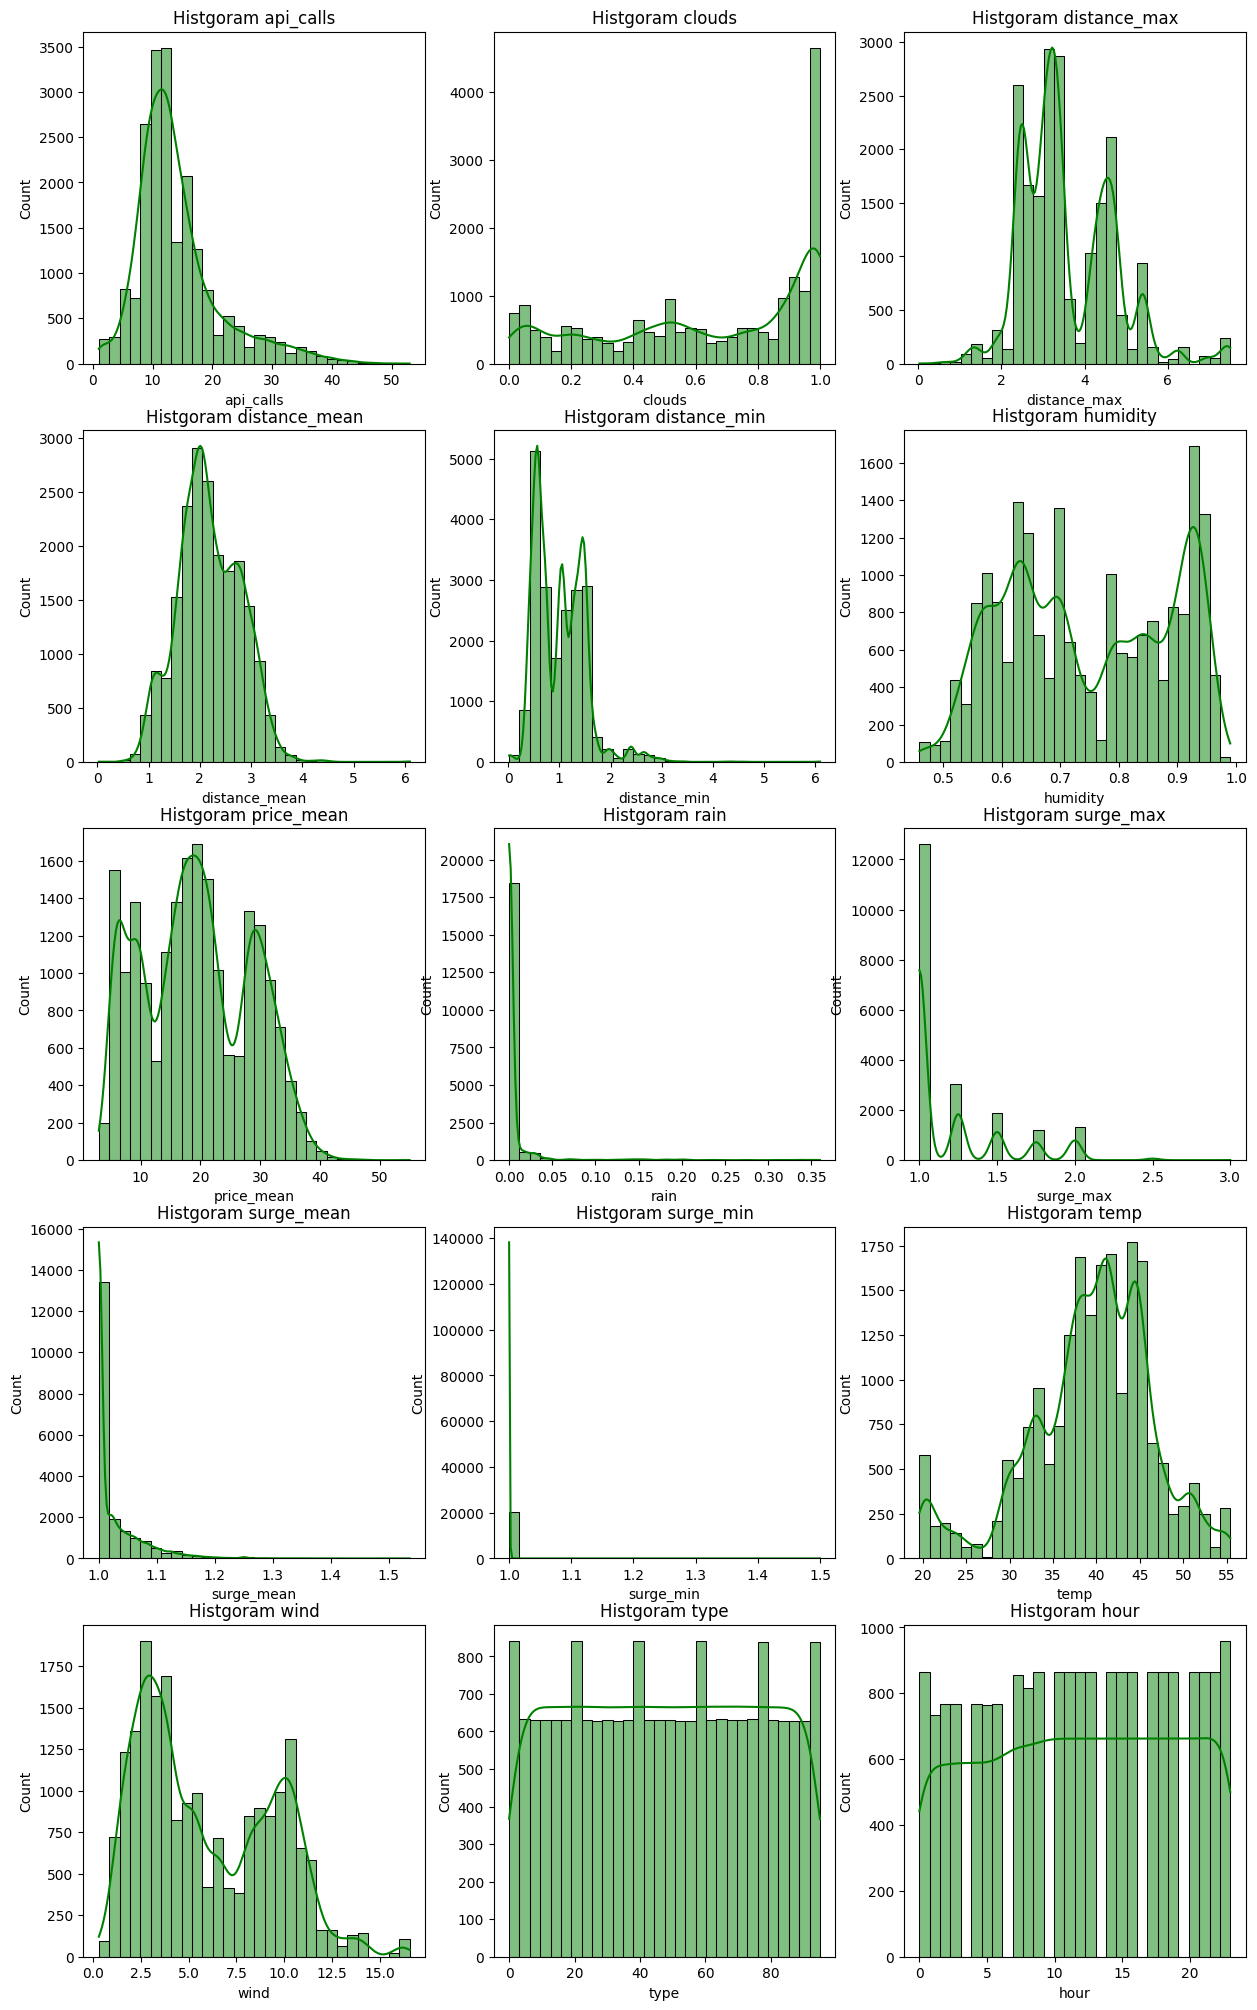

In [123]:
fig , ax = plt.subplots(5, 3, figsize=(15, 25))
ax = ax.flatten()

for i, column in enumerate(data.columns):
    sns.histplot(x=column, data=data, color='green', ax=ax[i] , kde=True , bins=30)
    ax[i].set_title(f'Histgoram {column}')

for j in range(i+1, 5*3):
    fig.delaxes(ax[j])


------------------------------------------------------------------------------------------------------------------------------------------------

# 2. Feature Engineering

In [81]:
target = 'price_mean'
x = data.drop(target, axis=1)
y = data[target]

In [142]:
modelz = CatBoostRegressor(loss_function='RMSE', 
                            random_state=42
                          )
modelz.fit(x, y)

Learning rate set to 0.065811
0:	learn: 8.4265960	total: 4.62ms	remaining: 4.62s
1:	learn: 7.9391033	total: 7.23ms	remaining: 3.61s
2:	learn: 7.5056785	total: 10.5ms	remaining: 3.47s
3:	learn: 7.0925780	total: 12.8ms	remaining: 3.2s
4:	learn: 6.7190951	total: 14.8ms	remaining: 2.95s
5:	learn: 6.3452512	total: 16.9ms	remaining: 2.81s
6:	learn: 5.9959125	total: 19.3ms	remaining: 2.73s
7:	learn: 5.6610630	total: 21.9ms	remaining: 2.72s
8:	learn: 5.3857979	total: 24.1ms	remaining: 2.66s
9:	learn: 5.1239810	total: 26.3ms	remaining: 2.6s
10:	learn: 4.8645789	total: 28.6ms	remaining: 2.57s
11:	learn: 4.6149497	total: 30.9ms	remaining: 2.55s
12:	learn: 4.3807807	total: 33.3ms	remaining: 2.53s
13:	learn: 4.1802104	total: 36.3ms	remaining: 2.56s
14:	learn: 3.9697436	total: 38.6ms	remaining: 2.54s
15:	learn: 3.7792274	total: 41.1ms	remaining: 2.53s
16:	learn: 3.6114667	total: 43.7ms	remaining: 2.52s
17:	learn: 3.4559675	total: 46.3ms	remaining: 2.53s
18:	learn: 3.3009891	total: 48.4ms	remaining: 

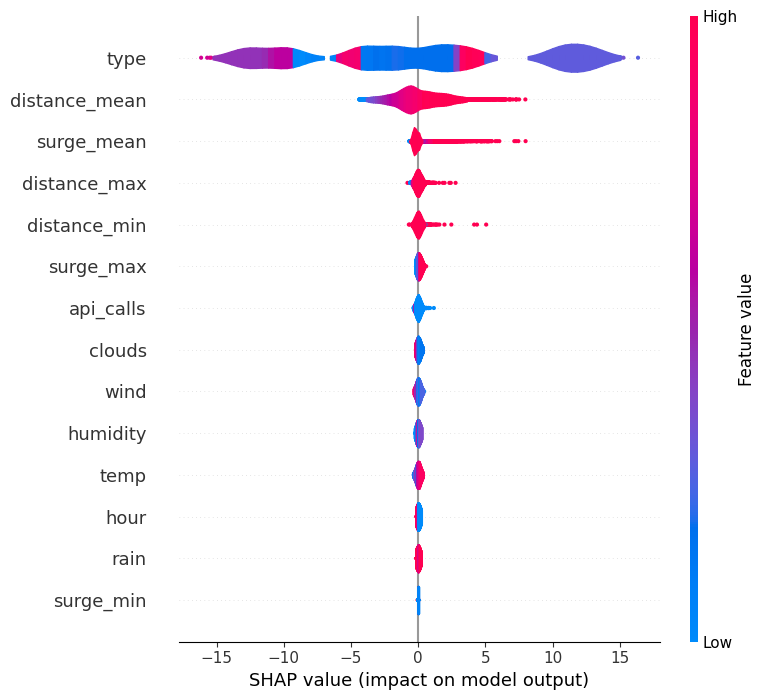

In [152]:
explainer = shap.TreeExplainer(modelz)
shap_values = explainer.shap_values(x)

shap.summary_plot(shap_values, x, plot_type='violin') 

feature_names = x.columns if hasattr(x, 'columns') else np.arange(x.shape[1])

shap_mean = np.abs(shap_values).mean(axis=0)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=shap_mean,
    y=feature_names,
    orientation='h'
))

fig.update_layout(
    title='SHAP Summary Plot',
    xaxis_title='SHAP Value (magnitude)',
    yaxis_title='Feature',
    yaxis_categoryorder='total ascending', 
    height=800, 
    margin=dict(l=100),  
)

fig.show()

In [163]:
def ols_test(data, target):
    best = ['type', 'distance_mean', 'surge_mean', 'distance_max', 'distance_min', 'surge_max']
    
    while True:
        x = data[best]
        y = data[target]

        model = sm.OLS(y, sm.add_constant(x))
        result = model.fit()

        pvalues = result.pvalues.drop('const')
        max_pvalue = pvalues.max()

        if max_pvalue > 0.05:
            variable_to_drop = pvalues.idxmax()
            best.remove(variable_to_drop)
        else:
            break
    
    return result.summary(), best

ols_test(data, target)

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:             price_mean   R-squared:                       0.068
 Model:                            OLS   Adj. R-squared:                  0.068
 Method:                 Least Squares   F-statistic:                     367.3
 Date:                Thu, 20 Jun 2024   Prob (F-statistic):          8.01e-306
 Time:                        23:06:24   Log-Likelihood:                -72071.
 No. Observations:               20163   AIC:                         1.442e+05
 Df Residuals:                   20158   BIC:                         1.442e+05
 Df Model:                           4                                         
 Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------

In [164]:
best = ['type', 'distance_mean', 'surge_mean', 'distance_max']

------------------------------------------------------------------------

# 3. Modelling

In [206]:
x = data[best]
y = data[target]

In [215]:
model = CatBoostRegressor(loss_function='RMSE', 
                          score_function = 'L2',
                          bootstrap_type = 'MVS',
                          boosting_type = 'Plain',
                          random_state=42,
                          )

In [216]:
x_train , x_test , y_train , y_test = tts(x, y, test_size=0.15, random_state=42)

In [217]:
model.fit(x_train, y_train)
print(f'MSE : {mse(y_test, model.predict(x_test), squared=False)}')
print(f'RMSE : {mse(y_test, model.predict(x_test), squared=True)}')

Learning rate set to 0.064142
0:	learn: 8.4283805	total: 4.38ms	remaining: 4.37s
1:	learn: 7.9392071	total: 6.55ms	remaining: 3.27s
2:	learn: 7.4840123	total: 8.55ms	remaining: 2.84s
3:	learn: 7.0607098	total: 10.4ms	remaining: 2.6s
4:	learn: 6.6669312	total: 13.2ms	remaining: 2.63s
5:	learn: 6.3002045	total: 16ms	remaining: 2.65s
6:	learn: 5.9571149	total: 19.5ms	remaining: 2.76s
7:	learn: 5.6371770	total: 22.4ms	remaining: 2.78s
8:	learn: 5.3371291	total: 24.9ms	remaining: 2.74s
9:	learn: 5.0591287	total: 26.9ms	remaining: 2.66s
10:	learn: 4.7986875	total: 29.2ms	remaining: 2.63s
11:	learn: 4.5564428	total: 31.2ms	remaining: 2.56s
12:	learn: 4.3317842	total: 33.7ms	remaining: 2.56s
13:	learn: 4.1195360	total: 35.8ms	remaining: 2.52s
14:	learn: 3.9232036	total: 37.8ms	remaining: 2.48s
15:	learn: 3.7396387	total: 39.5ms	remaining: 2.43s
16:	learn: 3.5695123	total: 41.4ms	remaining: 2.39s
17:	learn: 3.4085501	total: 43.2ms	remaining: 2.36s
18:	learn: 3.2599393	total: 45.5ms	remaining: 2

In [221]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 2000, 3000) ,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 0, 10),
        "depth": trial.suggest_int("depth", 4, 7),
        "subsample": trial.suggest_float("subsample", 0.05, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "border_count": trial.suggest_int("border_count", 1, 300),
        "loss_function": "RMSE",
        'score_function': 'L2' ,
        "boosting_type" : 'Plain'  , 'bootstrap_type':'MVS', 'random_state':42 }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(x_train, y_train , verbose=False)
    predictions = model.predict(x_test)
    rmse = mse(y_test, predictions, squared=True)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-06-20 23:36:32,714] A new study created in memory with name: no-name-3c483cff-6033-42a9-a33c-652afdfba3c4
[I 2024-06-20 23:36:36,632] Trial 0 finished with value: 0.3359671426093093 and parameters: {'iterations': 2546, 'learning_rate': 0.10500073040674965, 'l2_leaf_reg': 7.070721165033148, 'depth': 6, 'subsample': 0.5566213714882373, 'colsample_bylevel': 0.48949811598982607, 'min_data_in_leaf': 87, 'border_count': 192}. Best is trial 0 with value: 0.3359671426093093.
[I 2024-06-20 23:36:39,811] Trial 1 finished with value: 0.37860481386029354 and parameters: {'iterations': 2451, 'learning_rate': 0.030388159984357597, 'l2_leaf_reg': 9.399645455514309, 'depth': 7, 'subsample': 0.5342939032828186, 'colsample_bylevel': 0.3018122985687344, 'min_data_in_leaf': 44, 'border_count': 99}. Best is trial 0 with value: 0.3359671426093093.
[I 2024-06-20 23:36:43,729] Trial 2 finished with value: 0.34082718599727185 and parameters: {'iterations': 2568, 'learning_rate': 0.18501413574472889, 'l

Best hyperparameters: {'iterations': 2412, 'learning_rate': 0.04268005856874353, 'l2_leaf_reg': 2.5327582101523234, 'depth': 7, 'subsample': 0.6259597870492131, 'colsample_bylevel': 0.9980806096320909, 'min_data_in_leaf': 63, 'border_count': 120}
Best RMSE: 0.3116928706541573


In [234]:
best_params = {'iterations': 2412, 'learning_rate': 0.04268005856874353, 'l2_leaf_reg': 2.5327582101523234, 'depth': 7, 'subsample': 0.6259597870492131, 'colsample_bylevel': 0.9980806096320909, 'min_data_in_leaf': 63, 'border_count': 120}

------------------------------------------------------------------------------------

# 4. Modelling

In [235]:
model = CatBoostRegressor(loss_function='RMSE', 
                          score_function = 'L2',
                          bootstrap_type = 'MVS',
                          boosting_type = 'Plain',
                          random_state=42,
                          **best_params,
                          silent=True
                          )

In [236]:
model.fit(x_train, y_train)

In [260]:
model.save_model('model_zzeiidan.cbm', format='cbm')

------------------------------------------------------------------------------------

# 5. Predicting

In [244]:
sample

index  price_mean
0          0           0
1          1           0
2          2           0
3          3           0
4          4           0
...      ...         ...
11035  11035           0
11036  11036           0
11037  11037           0
11038  11038           0
11039  11039           0

[11040 rows x 2 columns]

In [239]:
test

index            timestamp  api_calls  clouds  distance_max  \
0          0  2018-12-14 00:00:00       13.0    0.69          3.02   
1          1  2018-12-14 01:00:00       14.0    0.77          2.34   
2          2  2018-12-14 02:00:00       13.0    0.59          3.00   
3          3  2018-12-14 03:00:00       12.0    0.68          3.14   
4          4  2018-12-14 04:00:00        7.0    0.72          2.41   
...      ...                  ...        ...     ...           ...   
11035  11035  2018-12-18 14:00:00       11.0    0.48          3.08   
11036  11036  2018-12-18 15:00:00       16.0    0.34          3.20   
11037  11037  2018-12-18 16:00:00        7.0    0.31          3.08   
11038  11038  2018-12-18 17:00:00        8.0    0.15          3.20   
11039  11039  2018-12-18 18:00:00        9.0    0.00          3.15   

       distance_mean  distance_min  humidity  rain  surge_max  surge_mean  \
0           1.980000          1.06      0.68   0.0       2.00    1.115385   
1           1.541429          1.04      0.68   0.0       1.00    1.000000   
2           2.010769          1.08      0.69   0.0       1.50    1.096154   
3           1.860833          1.06      0.70   0.0       1.25    1.020833   
4           1.634286          1.06      0.71   0.0       1.25    1.035714   
...              ...           ...       ...   ...        ...         ...   
11035       2.024545          0.72      0.47   0.0       1.00    1.000000   
11036       2.002500          0.72      0.46   0.0       1.00    1.000000   
11037       2.105714          0.72      0.47   0.0       1.00    1.000000   
11038       1.952500          0.72      0.46   0.0       1.00    1.000000   
11039       2.721111          1.06      0.46   0.0       1.00    1.000000   

       surge_min   temp   wind  type  
0            1.0  29.93   1.99     0  
1            1.0  30.19   2.35     0  
2            1.0  30.02   1.98     0  
3            1.0  29.89   1.92     0  
4            1.0  29.92   1.58     0  
...          ...    ...    ...   ...  
11035        1.0  26.19  13.89    95  
11036        1.0  27.22  15.03    95  
11037        1.0  28.70  14.60    95  
11038        1.0  30.05  13.55    95  
11039        1.0  30.79  13.09    95  

[11040 rows x 15 columns]

In [248]:
prediktor = model.predict(test[best])

In [255]:
index = pd.DataFrame(test.index , columns=['index'])
price_mean = pd.DataFrame(prediktor , columns=['price_mean'])

submission = pd.concat([index, price_mean], axis=1)

In [258]:
submission

index  price_mean
0          0   18.761702
1          1   14.394215
2          2   18.447184
3          3   16.300139
4          4   15.544842
...      ...         ...
11035  11035   29.571200
11036  11036   29.516840
11037  11037   29.738506
11038  11038   29.436837
11039  11039   31.607490

[11040 rows x 2 columns]

In [261]:
submission.to_csv('submission.csv', index=False)